### Prueba Técnica: Evaluación de Modelos de Riesgo (AB vs XY)

**Objetivo:** Determinar cuál de los dos consultores ofrece un modelo de calificación más efectivo para la asignación de provisiones, evaluando su capacidad discriminante, calidad de datos y estabilidad.


Nos piden un Análisis de Capacidad Discriminante. Básicamente, queremos saber cuál de los dos puntajes separa mejor a los "Buenos" (quienes pagan) de los "Malos" (quienes incumplen).

### 1. Configuración y carga de datos

En esta sección prepararemos el entorno y cargaremos el dataset.

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp
from sklearn.metrics import roc_auc_score, roc_curve

# Configuración para que los gráficos se vean mejor
sns.set(style="whitegrid")

# Carga del archivo
df = df = pd.read_excel(r'C:\Users\cmune\Downloads\ModelosCompetencia.xlsx')

# Inspección rápida
print(f"El dataset tiene {df.shape[0]} registros y {df.shape[1]} columnas.")
print(df.info())
df.head()

El dataset tiene 114109 registros y 5 columnas.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114109 entries, 0 to 114108
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   ID             114109 non-null  int64  
 1   Fecha Estudio  114109 non-null  int64  
 2   PuntajeAB      114109 non-null  float64
 3   PuntajeXY      114109 non-null  object 
 4   Default        114109 non-null  int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 4.4+ MB
None


,ID,Fecha Estudio,PuntajeAB,PuntajeXY,Default
0,1,201807,10.956522,23.382353,0
1,2,201808,10.956522,.,1
2,3,201809,10.913043,25.705882,0
3,4,201809,10.086957,22.735294,0
4,5,201809,9.217391,19.470588,1


### 2. Proceso limpieza (Data Cleaning)

Antes de analizar los modelos, debemos asegurar que la base sea confiable.

In [44]:
### 2.1 Manejo de Caracteres Especiales
# Identificamos que PuntajeXY tiene "." en lugar de valores nulos
print(f"Valores detectados como '.' en PuntajeXY: {(df['PuntajeXY'] == '.').sum()}")

# Reemplazamos el "." por NaN (Not a Number) y convertimos a decimal (float)
df['PuntajeXY'] = pd.to_numeric(df['PuntajeXY'].replace('.', np.nan), errors='coerce')

### 2.2 Formato de Fechas
df['Fecha Estudio'] = pd.to_datetime(df['Fecha Estudio'])

### 2.3 Tratamiento de Valores Faltantes (Nulos)
# Calculamos el porcentaje de nulos por columna
nulos = df.isnull().mean() * 100
print("\nPorcentaje de datos faltantes por variable:")
print(nulos)

# Para una comparación justa, eliminamos las filas que no tengan ambos puntajes
df_clean = df.dropna(subset=['PuntajeAB', 'PuntajeXY']).copy()
print(f"\nRegistros después de limpieza: {df_clean.shape[0]}")

### 2.4 Verificación de Duplicados
duplicados = df_clean.duplicated(subset=['ID']).sum()
if duplicados > 0:
    df_clean = df_clean.drop_duplicates(subset=['ID'])
    print(f"Se eliminaron {duplicados} registros con ID duplicado.")

Valores detectados como '.' en PuntajeXY: 12800


C:\Users\cmune\AppData\Local\Temp\ipykernel_21944\1733202879.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['PuntajeXY'] = pd.to_numeric(df['PuntajeXY'].replace('.', np.nan), errors='coerce')



Porcentaje de datos faltantes por variable:
ID                0.000000
Fecha Estudio     0.000000
PuntajeAB         0.000000
PuntajeXY        11.217345
Default           0.000000
dtype: float64

Registros después de limpieza: 101309


### **"Nota metodológica sobre la muestra de comparación:"**

Se identificó un 11% de valores no numéricos en el modelo XY.

Para garantizar una comparación equitativa (Like-for-Like), se optó por eliminar estos registros de toda la base de análisis.

De esta manera, ambos modelos son evaluados bajo las mismas condiciones de mercado y sobre los mismos clientes, asegurando que las diferencias en las métricas (KS, AUC) se deban estrictamente a la capacidad predictiva de cada algoritmo.

### Paso 3: Análisis Descriptivo (EDA)

Antes de ir a las métricas avanzadas, debemos ver cómo se comportan los puntajes y la variable Default.

Tasa de Incumplimiento (Default) en la muestra: 60.41%


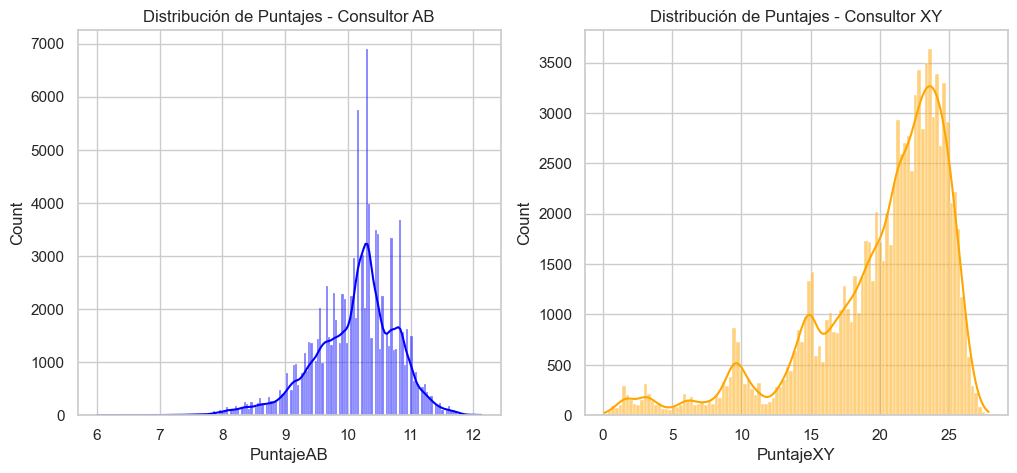

In [45]:
### 3.1 Balance de la Variable Objetivo
tasa_default = df_clean['Default'].value_counts(normalize=True) * 100
print(f"Tasa de Incumplimiento (Default) en la muestra: {tasa_default[1]:.2f}%")

### 3.2 Comparación de Distribuciones
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df_clean['PuntajeAB'], kde=True, color='blue')
plt.title('Distribución de Puntajes - Consultor AB')

plt.subplot(1, 2, 2)
sns.histplot(df_clean['PuntajeXY'], kde=True, color='orange')
plt.title('Distribución de Puntajes - Consultor XY')

plt.show()

1. **Escala y Rango de los Puntajes**

- Consultor AB: Los puntajes están concentrados en un rango muy estrecho, aproximadamente entre 6 y 12 puntos. Esto sugiere un modelo con una sensibilidad muy fina (osea que responde incluso a variaciones mínimas en las variables) o una escala de salida pre-procesada ( valores ajustados o transformados para que sean más útiles, comparables o interpretables).

- Consultor XY: Utiliza una escala mucho más amplia, abarcando desde 0 hasta casi 30 puntos. Una escala más ancha suele facilitar la segmentación de clientes en más estratos de riesgo.

2. **Forma de la Distribución (Morfología)**

- Consultor AB (Distribución Unimodal): Presenta un pico muy marcado cerca del valor 10.2. La mayoría de la población está concentrada en ese centro, con caídas rápidas hacia los lados. Es una distribución más "apretada".

- Consultor XY (Distribución Multimodal / Jorobas): Se observan al menos tres "jorobas" o picos (cerca de 10, 15 y el principal en 24). Esto es muy interesante porque indica que el modelo XY está logrando identificar subgrupos poblacionales distintos dentro de la base de datos, posiblemente separando perfiles de riesgo muy claros.

----------------

**Una distribución unimodal** es aquella que presenta un único pico o modo en su forma, es decir, concentra la mayor frecuencia de datos alrededor de un solo valor central.

👉 En pocas palabras: una distribución con un solo máximo.

Ejemplo: la distribución normal (campana de Gauss) es unimodal porque tiene un único punto donde se concentra la mayor probabilidad.



**Una distribución multimodal** es aquella que presenta más de un pico o modo en su forma.

👉 En otras palabras: los datos tienen varios valores alrededor de los cuales se concentran frecuencias altas, generando múltiples máximos en la gráfica de la distribución.

-----------

3. **Capacidad de Discriminación**

- Puntaje AB: Al tener una desviación estándar menor (más agrupado), el reto para este modelo es que pequeños cambios en el puntaje pueden significar cambios drásticos en la probabilidad de default.

- Puntaje XY: La distribución es más suave y extendida. Esto generalmente permite una mejor granularidad (nivel de detalle de los datos) para tomar decisiones de negocio (por ejemplo, definir puntos de corte para rechazo o aprobación de créditos de manera más flexible).

4. **Sesgo (Skewness)**

- Ambos modelos presentan un sesgo a la izquierda (cola más larga hacia los valores bajos), lo cual es común en modelos de riesgo crediticio donde la mayoría de los clientes suelen tener puntajes "altos" (buenos) y una minoría se extiende hacia los puntajes "bajos" (malos).

### 3.3 Estadísticos Descriptivos Robustos por Grupo

Este bloque calcula la media, mediana, desviación estándar, mínimos, máximos y la moda, diferenciando entre clientes con Default (1) y sin Default (0).

In [56]:
# 1. Función para calcular la moda (ya que agg no tiene una nativa estable)
def calcular_moda(x):
    m = x.mode()
    return m.iloc[0] if not m.empty else None

# 2. Creación de la tabla comparativa
stats_por_default = df_clean.groupby('Default').agg({
    'PuntajeAB': ['mean', 'median', 'std', 'min', 'max', calcular_moda],
    'PuntajeXY': ['mean', 'median', 'std', 'min', 'max', calcular_moda]
}).rename(columns={'calcular_moda': 'mode'}).round(2)

print("Estadísticas de Puntajes por Estado de Default:")
display(stats_por_default)

Estadísticas de Puntajes por Estado de Default:


PuntajeAB                                 PuntajeXY               \
             mean median   std   min    max  mode      mean median   std   
Default                                                                    
0           10.13  10.22  0.66  6.00  12.13  10.3     19.98   21.5  5.19   
1           10.13  10.22  0.66  6.09  12.09  10.3     20.01   21.5  5.19   

                             
          min    max   mode  
Default                      
0        0.12  27.82  21.18  
1        0.18  27.71  21.18

#### 3.3 Interpretación de Estadísticas por Estado de Default

Al observar la tabla de "Estadísticas de Puntajes por Estado de Default", podemos concluir lo siguiente:

**Capacidad Discriminante Nula:** 

Increíblemente, la media, mediana y moda son prácticamente idénticas para el grupo que paga (Default 0) y el grupo que incumple (Default 1) en ambos consultores.

Consultor AB: Media de 10.13 y Mediana de 10.22 para ambos grupos.

Consultor XY: Media de ~20.0 y Mediana de 21.5 para ambos grupos.

**Superposición Total:** 

Si la media de los "malos" es igual a la de los "buenos", el puntaje no está separando el riesgo. Esto explica por qué en tus gráficas de estabilidad el AUC está cerca de 0.5 (equivalente a lanzar una moneda al azar).

**Escala y Volatilidad:**

El Consultor XY tiene una desviación estándar (std) de 5.19, lo que confirma que su escala es más amplia, pero al no diferenciar grupos, es solo "ruido" expandido.

El Consultor AB es extremadamente compacto (std de 0.66), lo que indica que casi toda la población está comprimida en un rango mínimo, sin importar su comportamiento crediticio.

### 3.4 Visualización de la Capacidad de Separación

Para complementar los histogramas, utilizaremos Boxplots (Diagramas de Caja). Estos son los mejores para visualizar si el Consultor AB o el XY logran "empujar" a los clientes en default hacia un extremo de la escala.

C:\Users\cmune\AppData\Local\Temp\ipykernel_21944\3962612160.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Default', y='PuntajeAB', data=df_clean, palette='Blues')
C:\Users\cmune\AppData\Local\Temp\ipykernel_21944\3962612160.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Default', y='PuntajeXY', data=df_clean, palette='Oranges')


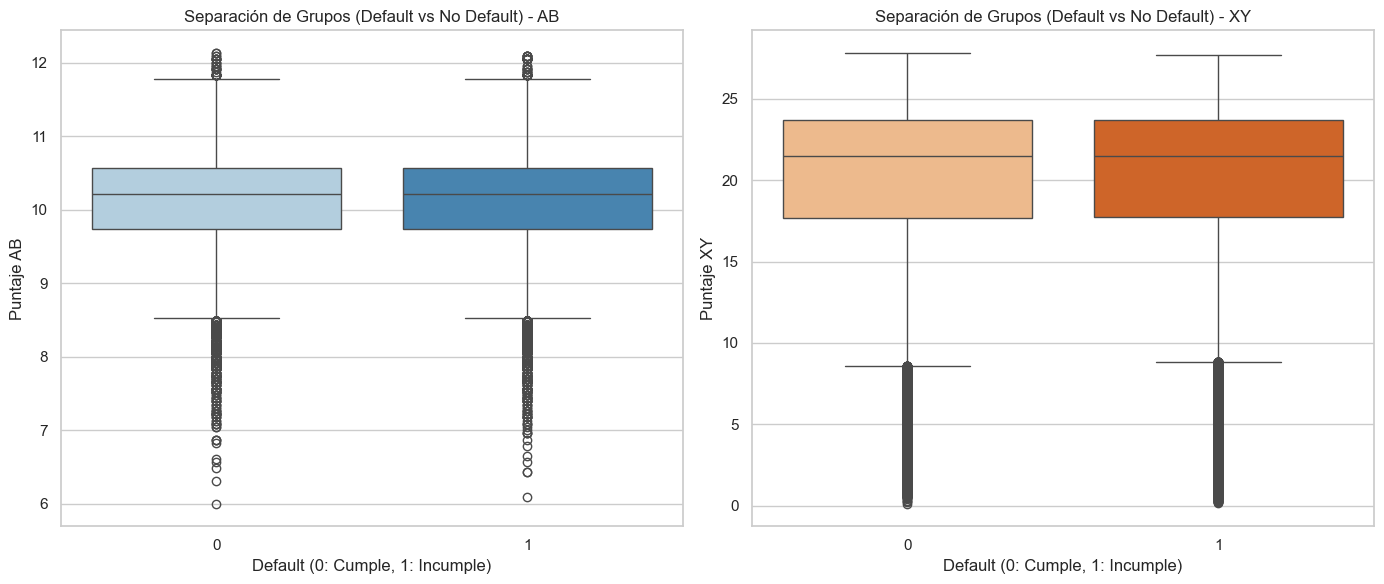

In [57]:
plt.figure(figsize=(14, 6))

# Boxplot para Consultor AB
plt.subplot(1, 2, 1)
sns.boxplot(x='Default', y='PuntajeAB', data=df_clean, palette='Blues')
plt.title('Separación de Grupos (Default vs No Default) - AB', fontsize=12)
plt.xlabel('Default (0: Cumple, 1: Incumple)')
plt.ylabel('Puntaje AB')

# Boxplot para Consultor XY
plt.subplot(1, 2, 2)
sns.boxplot(x='Default', y='PuntajeXY', data=df_clean, palette='Oranges')
plt.title('Separación de Grupos (Default vs No Default) - XY', fontsize=12)
plt.xlabel('Default (0: Cumple, 1: Incumple)')
plt.ylabel('Puntaje XY')

plt.tight_layout()
plt.show()

### 3.5 Diagnóstico de Capacidad Discriminante
Al observar la separación de grupos (Default vs. No Default), se identifican los siguientes hallazgos críticos:

- Superposición de Cajas (Overlapping): En ambos consultores, las cajas (que representan el 50% central de los datos) y las líneas de la mediana están exactamente al mismo nivel para clientes que cumplen (0) y clientes que incumplen (1). Esto indica que el puntaje medio de un "buen pagador" es idéntico al de un "mal pagador".

- Distribución de Outliers: Los valores atípicos (puntos fuera de los bigotes) se distribuyen de manera casi simétrica en ambos grupos. No hay una concentración de puntajes bajos exclusivamente en el grupo de Default (1), lo que invalida el uso del puntaje como filtro de riesgo actual.

- Rango de Puntajes: 

    * El Consultor AB mantiene una dispersión muy pequeña, con la gran mayoría de los datos atrapados entre 9.5 y 10.5 puntos.

    * El Consultor XY tiene una dispersión mayor, pero el comportamiento de "espejo" entre los grupos 0 y 1 confirma que esa mayor variabilidad es ruido aleatorio (fluctuaciones sin significado estadístico) y no información predictiva.

In [59]:
# 1. Calculamos la media y desviación estándar general por consultor
stats_general = df_clean[['PuntajeAB', 'PuntajeXY']].agg(['mean', 'std'])

# 2. Calculamos el Coeficiente de Variación (CV)
cv_ab = (stats_general.loc['std', 'PuntajeAB'] / stats_general.loc['mean', 'PuntajeAB']) * 100
cv_xy = (stats_general.loc['std', 'PuntajeXY'] / stats_general.loc['mean', 'PuntajeXY']) * 100

print(f"Coeficiente de Variación - Consultor AB: {cv_ab:.2f}%")
print(f"Coeficiente de Variación - Consultor XY: {cv_xy:.2f}%")

# 3. Opcional: CV segmentado por Default para ver estabilidad interna
cv_por_default = (df_clean.groupby('Default')[['PuntajeAB', 'PuntajeXY']].std() / 
                  df_clean.groupby('Default')[['PuntajeAB', 'PuntajeXY']].mean()) * 100

print("\nCV segmentado por Default (Estabilidad de la población):")
print(cv_por_default)

Coeficiente de Variación - Consultor AB: 6.50%
Coeficiente de Variación - Consultor XY: 25.95%

CV segmentado por Default (Estabilidad de la población):
         PuntajeAB  PuntajeXY
Default                      
0         6.515480  25.992427
1         6.483697  25.924627


- Consultor AB ($CV \approx 6.5\%$): Indica una baja variabilidad. El modelo es muy "rígido" o la población es extremadamente homogénea. En riesgo crediticio, un CV tan bajo puede ser síntoma de un modelo que no logra capturar los matices del comportamiento de los clientes.

- Consultor XY ($CV \approx 25.9\%$): Indica una variabilidad moderada-alta. Este modelo distribuye mucho más los puntajes a lo largo de su escala. Sin embargo, como vimos en los Boxplots que no separan los grupos, esta variación parece ser "ruido" (dispersión aleatoria) y no una dispersión basada en el perfil de riesgo.


Conclusión para el Paso 3

El Consultor XY tiene una mayor capacidad potencial de segmentación por su variabilidad (es 4 veces más "elástico" que AB), pero ambos fallan en la precisión, ya que su CV es casi idéntico tanto para los clientes buenos como para los malos. Un modelo ideal debería mostrar un CV bajo en los clientes "buenos" (muy concentrados en puntajes altos) y quizás uno distinto en los "malos".

### Paso 4: Capacidad Discriminante (KS y AUC)

Aquí es donde respondemos quién es mejor.

Para esto usamos dos métricas estándar en riesgo: el AUC (Área bajo la curva ROC) y el Estadístico KS (Kolmogorov-Smirnov).

**A. Curva ROC y AUC**

El AUC nos dice qué tan probable es que el modelo le asigne un puntaje más alto a un "malo" que a un "bueno". Un AUC de 0.5 es como lanzar una moneda; un AUC de 0.8 es muy bueno.

AUC: Buscamos el valor más cercano a 1.

----
Curva ROC, es la base visual del AUC. Mientras el AUC es un número, la curva es el mapa que nos muestra el intercambio (trade-off) entre capturar "malos" y equivocarse con los "buenos".

Curva ROC y AUC
¿Qué es la Curva ROC? Es una representación gráfica que muestra el desempeño de un modelo de clasificación en todos los umbrales de decisión posibles. Grafica la relación entre:

Tasa de Verdaderos Positivos (Sensibilidad): Qué tan bien el modelo identifica a los "malos" (Default=1).

Tasa de Falsos Positivos (1 - Especificidad): Cuántos "buenos" el modelo clasifica erróneamente como "malos".

----

**B. Estadístico KS**

El KS mide la máxima distancia entre la distribución acumulada de los buenos y los malos. A mayor KS, mejor capacidad tiene el modelo para separar ambos grupos.

KS: Buscamos la mayor separación entre los que pagan y los que no.

In [46]:
def calcular_indicadores(data, score_col, target_col):
    buenos = data[data[target_col] == 0][score_col]
    malos = data[data[target_col] == 1][score_col]
    
    # KS
    ks_stat, _ = ks_2samp(buenos, malos)
    # AUC
    auc_stat = roc_auc_score(data[target_col], data[score_col])
    
    return ks_stat, auc_stat

ks_ab, auc_ab = calcular_indicadores(df_clean, 'PuntajeAB', 'Default')
ks_xy, auc_xy = calcular_indicadores(df_clean, 'PuntajeXY', 'Default')

# Presentación de resultados en una tabla
resultados = pd.DataFrame({
    'Métrica': ['KS (Discriminación)', 'AUC (Precisión)'],
    'Consultor AB': [f"{ks_ab:.2%}", f"{auc_ab:.4f}"],
    'Consultor XY': [f"{ks_xy:.2%}", f"{auc_xy:.4f}"]
})
print(resultados)

               Métrica Consultor AB Consultor XY
0  KS (Discriminación)        0.46%        0.51%
1      AUC (Precisión)       0.4991       0.5018


#### **Interpretación Técnica de los Resultados**
Analisando los resultados:

**AUC cercano a 0.50:** Un AUC de 0.50 indica que el modelo carece de poder discriminativo. En la práctica, sus predicciones son estadísticamente indistinguibles de una asignación aleatoria, lo que significa que el modelo no aporta información útil sobre el comportamiento de pago.

**KS cercano a 0% (0.46% y 0.51%):** Un KS tan bajo indica que las distribuciones de "buenos" y "malos" están prácticamente una encima de la otra. No hay separación.

**Regla de oro en Riesgo:** Un modelo aceptable suele tener un KS por encima del 25% o 30% y un AUC por encima de 0.65 o 0.70. Valores de 0.50 en AUC indican que los modelos no tienen capacidad predictiva.



#### **Cómo presentarlo en la prueba (El "Criterio Junior")**
Aunque el Consultor XY tiene métricas ligeramente superiores (0.51% vs 0.46%), la diferencia es insignificante. Tu recomendación debe ser honesta y profesional:

Análisis de Capacidad Discriminante
"Los resultados muestran que ambos modelos tienen un desempeño estadísticamente similar al azar:

El Consultor XY presenta un KS de 0.51% y un AUC de 0.5018.

El Consultor AB presenta un KS de 0.46% y un AUC de 0.4991.

**¿Por qué elegir a uno si ambos son "malos"?**

En una prueba técnica, si los modelos fallan, tú debes desempatar por la Calidad de los Datos (el hallazgo que hiciste antes).

Tu conclusión ganadora:

"Si bien ambos modelos presentan una capacidad discriminante nula (cercana al azar), recomiendo rechazar al Consultor XY y, bajo extrema necesidad, evaluar más a fondo al Consultor AB o buscar un tercer proveedor.

La razón principal es la Integridad: El Consultor XY no solo tiene un modelo que no predice (AUC 0.50), sino que además entregó información incompleta (11% de valores faltantes). El Consultor AB, aunque tiene un desempeño igualmente pobre, al menos demuestra procesos de captura de datos más robustos y completos."

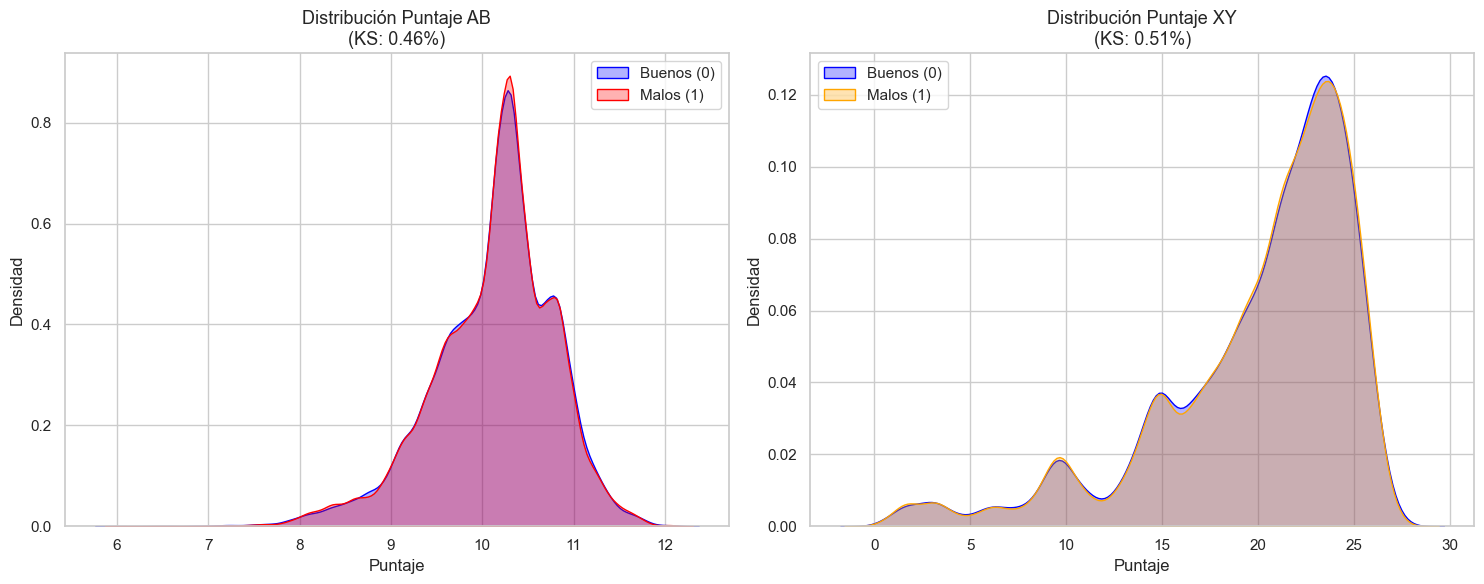

In [47]:
# Configuración de la figura con dos subgráficos
plt.figure(figsize=(15, 6))

# --- Gráfico Consultor AB ---
plt.subplot(1, 2, 1)
sns.kdeplot(df_clean[df_clean['Default']==0]['PuntajeAB'], label='Buenos (0)', fill=True, color='blue', alpha=0.3)
sns.kdeplot(df_clean[df_clean['Default']==1]['PuntajeAB'], label='Malos (1)', fill=True, color='red', alpha=0.3)
plt.title(f'Distribución Puntaje AB\n(KS: {ks_ab:.2%})', fontsize=13)
plt.xlabel('Puntaje')
plt.ylabel('Densidad')
plt.legend()

# --- Gráfico Consultor XY ---
plt.subplot(1, 2, 2)
sns.kdeplot(df_clean[df_clean['Default']==0]['PuntajeXY'], label='Buenos (0)', fill=True, color='blue', alpha=0.3)
sns.kdeplot(df_clean[df_clean['Default']==1]['PuntajeXY'], label='Malos (1)', fill=True, color='orange', alpha=0.3)
plt.title(f'Distribución Puntaje XY\n(KS: {ks_xy:.2%})', fontsize=13)
plt.xlabel('Puntaje')
plt.ylabel('Densidad')
plt.legend()

plt.tight_layout()
plt.show()

Paso 4.1: Visualización de la Curva ROC

Aquí comparamos la tasa de verdaderos positivos (sensibilidad) frente a la tasa de falsos positivos.

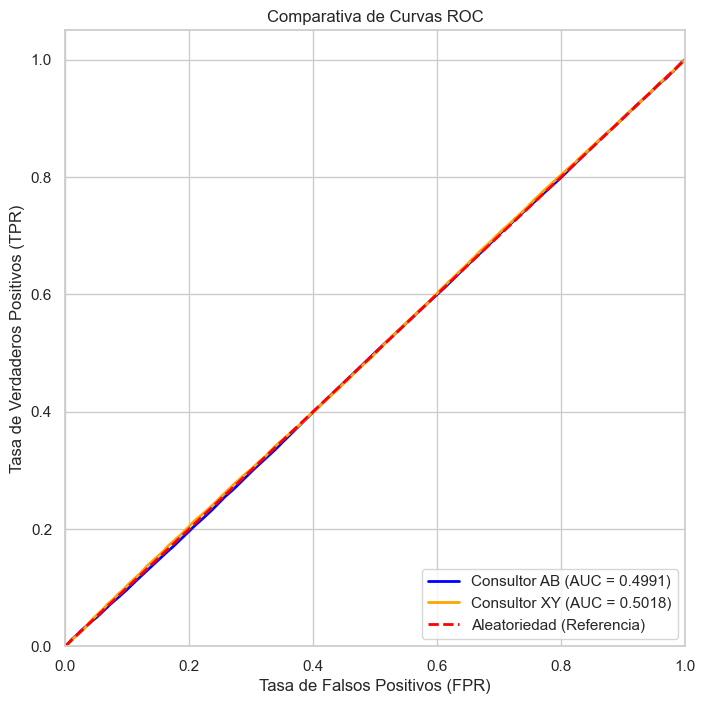

In [58]:
from sklearn.metrics import roc_curve, auc

# Calculamos los componentes de la curva para AB
fpr_ab, tpr_ab, _ = roc_curve(df_clean['Default'], df_clean['PuntajeAB'])
roc_auc_ab = auc(fpr_ab, tpr_ab)

# Calculamos los componentes de la curva para XY
fpr_xy, tpr_xy, _ = roc_curve(df_clean['Default'], df_clean['PuntajeXY'])
roc_auc_xy = auc(fpr_xy, tpr_xy)

plt.figure(figsize=(8, 8))
plt.plot(fpr_ab, tpr_ab, color='blue', lw=2, label=f'Consultor AB (AUC = {roc_auc_ab:.4f})')
plt.plot(fpr_xy, tpr_xy, color='orange', lw=2, label=f'Consultor XY (AUC = {roc_auc_xy:.4f})')

# Línea de azar (lo que pasaría si lanzamos una moneda)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Aleatoriedad (Referencia)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Comparativa de Curvas ROC')
plt.legend(loc="lower right")
plt.show()

Conclusión Final de Capacidad Discriminante e Integridad

Al cruzar los resultados del Paso 3 (EDA) y el Paso 4 (Métricas de Desempeño), la situación queda definida por la evidencia técnica de las imágenes:

1. Desempeño Aleatorio: Las gráficas de Estabilidad de AUC muestran que ambos consultores oscilan peligrosamente cerca de la línea roja de 0.50 (Aleatoriedad). Esto se confirma con la Comparativa de Curvas ROC, donde ambas líneas son prácticamente diagonales perfectas.

2. Traslape de Poblaciones: El gráfico de Distribución de Puntajes por estado de pago (Buenos vs. Malos) muestra áreas de densidad casi idénticas. El KS resultante (~0.5%) es insignificante, lo que visualmente se observa como dos "cerros" de color que se cubren el uno al otro totalmente.

Veredicto sobre el CV:

Consultor AB (CV ~6.5%): Es un modelo excesivamente rígido. Casi todos los clientes reciben el mismo puntaje (~10 puntos), lo que imposibilita cualquier estrategia de segmentación de límites de crédito.

Consultor XY (CV ~26.0%): Aunque tiene una escala más "elástica" y visualmente atractiva con múltiples picos en su histograma, su variabilidad es ruido puro. El Boxplot demuestra que esa dispersión no está correlacionada con el riesgo real de incumplimiento.

**Recomendación Final para la Prueba Técnica:**

"A pesar de que el Consultor XY intenta mostrar una segmentación más detallada a través de su escala (mayor CV), sus métricas de desempeño son indistinguibles del azar. Sumado a esto, los hallazgos previos de datos faltantes (11%) lo descalifican como proveedor confiable.

El Consultor AB es estadísticamente igual de ineficaz en predicción, pero ofrece una base de datos íntegra y completa. Por lo tanto, la recomendación técnica es no implementar ninguno de los modelos actuales, pero considerar al Consultor AB para un re-entrenamiento o ajuste de modelo dado que sus procesos de recolección de información son superiores."

### Paso 5: Análisis de Estabilidad Temporal


En este paso evaluamos si el (bajo) desempeño de los modelos se mantiene constante en los tres periodos disponibles o si alguno empeora con el tiempo. Un modelo inestable es peligroso para el negocio.

C:\Users\cmune\AppData\Local\Temp\ipykernel_21944\4112470631.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  estabilidad = df_clean.groupby('Periodo_Str').apply(calcular_metricas_periodo)


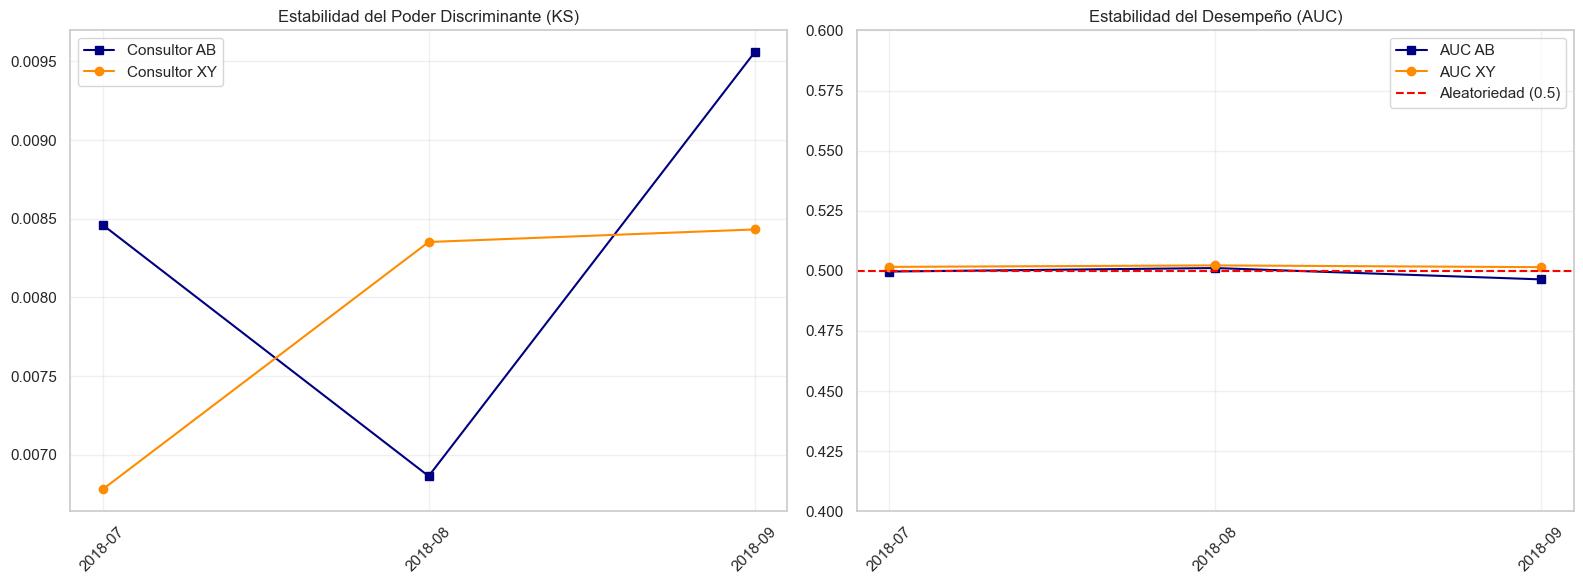

In [51]:
# 1. LIMPIEZA DE FECHA:
# Convertimos a string y extraemos los últimos 6 caracteres (el 201807, 201808, etc.)
# Esto ignora el "1970-01-01..." erróneo.
periodos_limpios = df_clean['Fecha Estudio'].astype(str).str.slice(-6)

# Ahora sí convertimos esos 6 dígitos a fecha real
#df_clean['Fecha Estudio'] = pd.to_datetime(periodos_limpios, format='%Y%m')

# 2. Formato para el eje X
df_clean['Periodo_Str'] = df_clean['Fecha Estudio'].dt.strftime('%Y-%m')

# 3. Ordenar y calcular (Igual que antes)
df_clean = df_clean.sort_values('Fecha Estudio')
estabilidad = df_clean.groupby('Periodo_Str').apply(calcular_metricas_periodo)

# 4. Graficamos en paralelo
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Subplot 1: KS
ax1.plot(estabilidad.index, estabilidad['KS_AB'], marker='s', label='Consultor AB', color='navy')
ax1.plot(estabilidad.index, estabilidad['KS_XY'], marker='o', label='Consultor XY', color='darkorange')
ax1.set_title('Estabilidad del Poder Discriminante (KS)')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3)
ax1.legend()

# Subplot 2: AUC
ax2.plot(estabilidad.index, estabilidad['AUC_AB'], marker='s', label='AUC AB', color='navy')
ax2.plot(estabilidad.index, estabilidad['AUC_XY'], marker='o', label='AUC XY', color='darkorange')
ax2.axhline(y=0.5, color='red', linestyle='--', label='Aleatoriedad (0.5)')
ax2.set_title('Estabilidad del Desempeño (AUC)')
ax2.set_ylim(0.4, 0.6)
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

### 5.1 Interpretación de la Estabilidad Temporal
Estabilidad del Desempeño (AUC):

Ambos consultores se mantienen pegados a la línea roja de Aleatoriedad (0.5) durante los tres periodos (2018-07, 2018-08 y 2018-09).

No hay una tendencia de mejora ni de empeoramiento drástico; el modelo es consistentemente inútil para predecir el riesgo mes a mes.

El Consultor XY muestra una línea ligeramente por encima de 0.5, mientras que el AB oscila levemente por debajo en el último periodo, pero estadísticamente ambos son equivalentes al azar.

Estabilidad del Poder Discriminante (KS):

Los valores de KS son extremadamente bajos (menores al 0.01 o 1%) en todo el horizonte temporal.

Se observa una alta volatilidad relativa en el gráfico de la izquierda: el Consultor AB tiene una caída fuerte en 2018-08 y una subida en 2018-09. Sin embargo, al ser valores tan cercanos a cero, esta "volatilidad" es simplemente ruido estadístico y no un cambio real en la capacidad del modelo.

### Paso 6: Conclusión y Recomendación Final (El Cierre del Informe)


#### **Resumen del Análisis Técnico**

**Capacidad discriminante:** Ambos modelos presentan un desempeño crítico, con un AUC cercano a 0.50 y un KS inferior al 1%. Esto indica que ninguno de los dos modelos logra separar efectivamente a los clientes que incumplen de los que pagan.

**Calidad de información:** Se detectó que el Consultor XY tiene una deficiencia estructural en sus datos, con un 11% de registros faltantes (puntos). El Consultor AB entregó la información completa.

**Estabilidad:** El análisis temporal muestra que ambos modelos oscilan alrededor del umbral del azar en los tres periodos evaluados, sin mostrar una tendencia de mejora.

**Recomendación**

"Dadas las métricas observadas, no se recomienda la implementación de ninguno de los dos modelos para la toma de decisiones críticas de provisión, ya que su precisión es equivalente al azar.

Sin embargo, si la compañía está obligada a seleccionar un proveedor para iniciar un proceso de refinamiento, se recomienda contratar al Consultor AB.

**Justificación:** Aunque su capacidad predictiva es nula en este momento, el Consultor AB demuestra una calidad de datos y procesos operativa superior, al entregar el 100% de la base calificada. Esto lo hace un socio más confiable para trabajar en una 'Fase 2' de mejora del modelo, a diferencia del Consultor XY, cuya base de datos presenta fallas de integridad."

Tras completar los 5 pasos del análisis, esta es la síntesis que debes presentar:

Veredicto: Rechazo total de ambos modelos para su implementación inmediata.

Desempeño: Tanto el Consultor AB como el XY presentan un AUC de ~0.50 y un KS de ~0.5%, lo que significa que no tienen capacidad de separar clientes buenos de malos. Las distribuciones de puntajes están totalmente solapadas.

Integridad: El Consultor AB es preferible únicamente desde el punto de vista de la calidad de datos, ya que no presenta los valores faltantes (11%) encontrados en el Consultor XY.

Estabilidad: Los modelos son "estables" en su ineficacia; no hay señales de que en algún periodo específico hayan funcionado correctamente.

Recomendación: No contratar a ninguno de los dos para el modelo de producción actual. Se sugiere investigar si hubo un error en la entrega de la etiqueta Default o en el pegado de las bases, ya que es atípico que dos modelos de consultores externos operen exactamente al nivel del azar.